In [32]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from tqdm import tqdm
import datetime as dt

import pdaactconn as pc
from trialexplorer.mesh_terms import MeSHCatalog
from trialexplorer import AACTStudySet

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tqdm.pandas()

In [3]:
# intializing MeSH object
mc = MeSHCatalog()

Parsing MeSH xml: xml/desc2020.xml ...
Parse Complete! (parsed ElementTree root can be found in the .root attribute)


In [4]:
# selecting all interventional studies
conn = pc.AACTConnection(source=pc.AACTConnection.LOCAL)
ss = AACTStudySet.AACTStudySet(conn= conn, tqdm_handler=tqdm_notebook)
ss.add_constraint("study_type = 'Interventional'")
ss.add_constraint("start_date is not Null")
ss.load_studies()

247950 studies loaded!


In [5]:
ss.add_dimensions('conditions')
ss.refresh_dim_data()

Successfuly added these 1 dimensions: ['conditions']
Failed to add these 0 dimensions: []


Syncing the temp table temp_cur_studies in 496 chunks x 500 records each

Creating index on the temp table
 - Loading dimension conditions
 -- Loading raw data
 -- Sorting index


In [6]:
c = ss.dimensions['conditions']

In [7]:
s_counts = c.data.groupby('downcase_name')['downcase_name'].count().sort_values(ascending=False)
s_sig = s_counts[s_counts > 500]

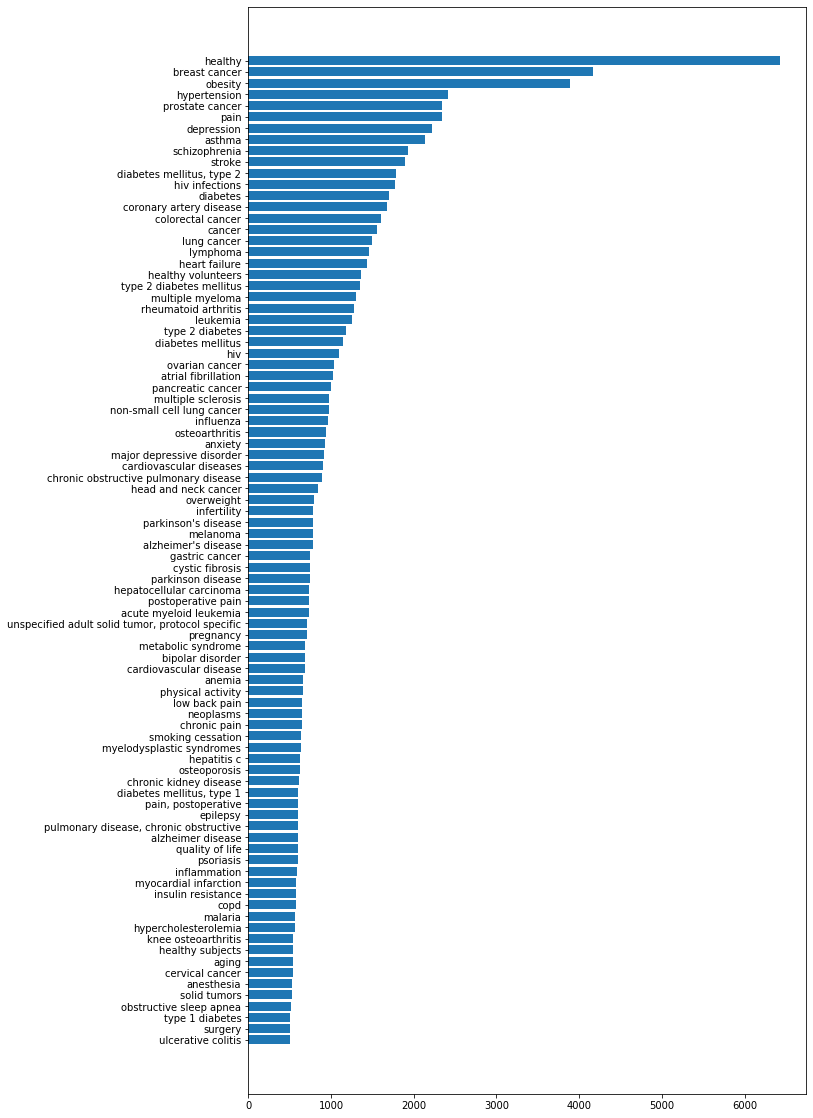

In [8]:
fig = plt.figure(figsize=(10, 20))
fig.tight_layout()
plt.barh(s_sig.index, s_sig)
plt.gca().invert_yaxis()
plt.show()

In [9]:
# manually map the top 1000 conditions
pd.DataFrame(s_counts)[0:1000].to_csv('manual_maps/top_conditions_unmapped.csv')

### work in excel to map the top 1000 conditions

In [10]:
df_mapped = pd.read_csv('manual_maps/top_conditions.csv', index_col='downcase_name')
s_g_counts = df_mapped.groupby('cond_group')['counts'].sum().sort_values(ascending=False)

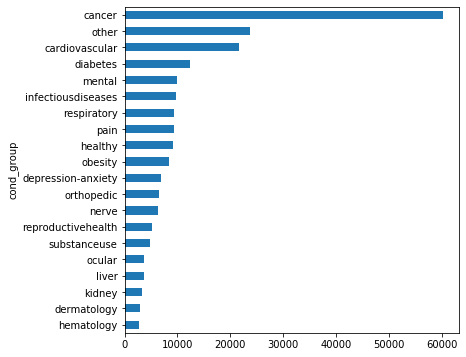

In [11]:
s_g_counts.plot.barh(figsize=(6,6))
plt.gca().invert_yaxis()
plt.show()

In [12]:
# for mapping conditions to their groups
cond2grp = df_mapped['cond_group'].to_dict()

### Let's look at the distribution of diseases over time

In [13]:
ss.studies.shape

(247950, 63)

In [14]:
c.data['category'] = c.data['downcase_name'].progress_apply(lambda x: cond2grp[x] 
                                                            if x in cond2grp.keys() 
                                                            else 'other')

100%|██████████| 408680/408680 [00:00<00:00, 1211837.34it/s]


In [15]:
all_categories = list(s_g_counts.index)
all_categories

['cancer',
 'other',
 'cardiovascular',
 'diabetes',
 'mental',
 'infectiousdiseases',
 'respiratory',
 'pain',
 'healthy',
 'obesity',
 'depression-anxiety',
 'orthopedic',
 'nerve',
 'reproductivehealth',
 'substanceuse',
 'ocular',
 'liver',
 'kidney',
 'dermatology',
 'hematology']

In [16]:
# method for combining all of the categories for a study
def combine_all_grps(df, nct_id):
    all_cond_grps = []
    if nct_id in df.index:
        sub_df = df.loc[[nct_id]]
        for cur_cat in sub_df['category']:
            if cur_cat not in all_cond_grps:
                all_cond_grps.append(cur_cat)
    return all_cond_grps

In [17]:
s_cats = ss.studies.reset_index()['nct_id'].progress_apply(lambda x: combine_all_grps(c.data, x)).values

100%|██████████| 247950/247950 [01:43<00:00, 2406.80it/s]


In [18]:
ss.studies['cond_categories'] = s_cats
ss.studies[['cond_categories']].head()

,cond_categories
nct_id,
NCT04072757,[obesity]
NCT04073069,"[pain, other]"
NCT04073056,"[obesity, other]"
NCT04073043,[depression-anxiety]
NCT04073017,[other]


### we now have a column that has a list representation of the categories per study

## Next, we can get the dummy variables per category

In [19]:
for cur_cat in all_categories:
    ss.studies['is_' + cur_cat] = ss.studies['cond_categories'].progress_apply(lambda x: 1 
                                                                               if cur_cat in x
                                                                               else 0)

100%|██████████| 247950/247950 [00:00<00:00, 1249651.74it/s]


In [20]:
ss.studies[['is_' + x for x in all_categories]].head()

,is_cancer,is_other,is_cardiovascular,is_diabetes,is_mental,is_infectiousdiseases,is_respiratory,is_pain,is_healthy,is_obesity,is_depression-anxiety,is_orthopedic,is_nerve,is_reproductivehealth,is_substanceuse,is_ocular,is_liver,is_kidney,is_dermatology,is_hematology
nct_id,,,,,,,,,,,,,,,,,,,,
NCT04072757,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
NCT04073069,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
NCT04073056,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
NCT04073043,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
NCT04073017,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [80]:
# let's see our count per category
dummy_categories = ['is_' + x for x in all_categories]
ss.studies[dummy_categories].sum()

is_cancer                 40046
is_other                 135713
is_cardiovascular         17706
is_diabetes               10878
is_mental                  8486
is_infectiousdiseases      7645
is_respiratory             8659
is_pain                    8660
is_healthy                 9135
is_obesity                 6975
is_depression-anxiety      5704
is_orthopedic              5967
is_nerve                   6071
is_reproductivehealth      4878
is_substanceuse            4072
is_ocular                  3085
is_liver                   3325
is_kidney                  2951
is_dermatology             2816
is_hematology              2458
dtype: int64

### Can group this by time windows and see what is studies at which times

In [24]:
ss.studies['start_year'] = ss.studies['start_date'].apply(lambda x: pd.Timestamp(x).year)

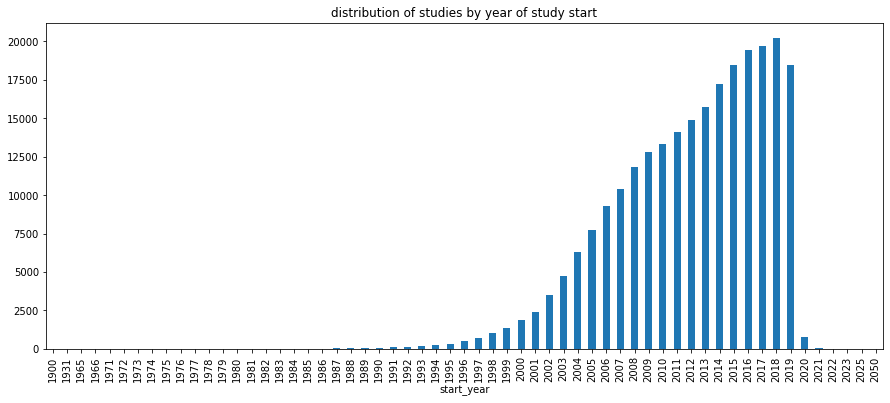

In [29]:
plt.figure(figsize=(15, 6))
ss.studies.groupby('start_year')['start_date'].count().plot.bar()
plt.title('distribution of studies by year of study start')
plt.show()

In [38]:
ss.studies.head(1).T.to_csv('example.csv')

In [52]:
# making a column with the year buckets
ss.studies['start_year_bucket'] = ss.studies['start_year'].apply(lambda x: '1999-' if x < 2000
                                                                 else ('2019+'
                                                                       if x > 2019 
                                                                       else str(x))
                                                                 )

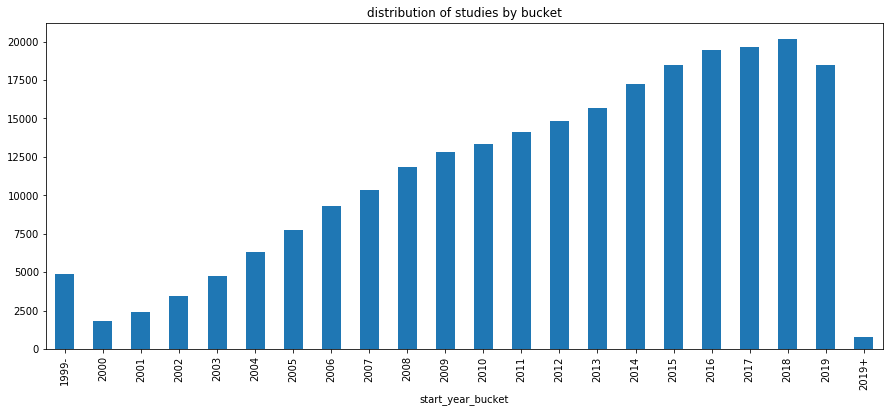

In [53]:
plt.figure(figsize=(15, 6))
ss.studies.groupby('start_year_bucket')['start_date'].count().plot.bar()
plt.title('distribution of studies by bucket')
plt.show()

### Now we can compute the % of studies studying each subject

**since each study can study multiple conditions, this % can add up to more than 100%**

In [81]:
all_buckets = ss.studies['start_year_bucket'].unique()
all_buckets

array(['2017', '2019', '2018', '2007', '2016', '2014', '2019+', '2013',
       '2015', '2011', '1999-', '2010', '2012', '2008', '2009', '2005',
       '2003', '2006', '2000', '2004', '2002', '2001'], dtype=object)

In [82]:
# calculating % studies in each bucket
bucket_dict = {}
for cur_bucket in all_buckets:
    sub_df = ss.studies[ss.studies['start_year_bucket'] == cur_bucket]
    bucket_dict[cur_bucket] = sub_df[dummy_categories].sum() / sub_df.shape[0]

In [161]:
# this data frame now contains the % of all studies in that year used on a certain group of studies
df_pcts = pd.DataFrame(bucket_dict)[sorted(bucket_dict.keys())]
df_pcts.reset_index()
df_pcts.index = df_pcts.reset_index()['index'].apply(lambda x: x[3:])
df_pcts.head()

,1999-,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2019+
index,,,,,,,,,,,,,,,,,,,,,
cancer,0.447068,0.428725,0.341290,0.269253,0.240219,0.226977,0.215544,0.201550,0.189036,0.175228,...,0.140048,0.130172,0.124339,0.124637,0.136566,0.133412,0.132771,0.131901,0.138592,0.104271
other,0.361767,0.369016,0.390704,0.404598,0.420067,0.419559,0.423057,0.452196,0.463628,0.468824,...,0.534214,0.567238,0.576788,0.579742,0.564843,0.593903,0.639099,0.644056,0.649726,0.683417
cardiovascular,0.072272,0.061323,0.067420,0.072701,0.087085,0.086702,0.090415,0.083549,0.083245,0.078151,...,0.076306,0.071241,0.074081,0.070450,0.065439,0.067143,0.062319,0.061593,0.059706,0.079146
diabetes,0.021173,0.032813,0.041457,0.048563,0.045225,0.047234,0.050389,0.053941,0.051643,0.051707,...,0.048197,0.047830,0.045608,0.045360,0.041116,0.038661,0.035480,0.034163,0.037276,0.027638
mental,0.020765,0.033351,0.038945,0.035920,0.040808,0.043906,0.039508,0.037468,0.035553,0.039878,...,0.030309,0.033569,0.028792,0.031188,0.032178,0.034960,0.032125,0.035748,0.039010,0.062814


### let's normalize the data to without "other" and drop really old and anticipated studies

In [160]:
df_no_other = df_pcts.drop("other").drop(['2019+', '1999-'], axis=1)
df_no_other = df_no_other / df_no_other.sum()
df_no_other.head()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
index,,,,,,,,,,,,,,,,,,,,
cancer,0.518543,0.428496,0.342972,0.311256,0.292543,0.284008,0.272807,0.265674,0.253452,0.240014,0.229267,0.219637,0.214976,0.210028,0.208067,0.224728,0.226183,0.228982,0.227498,0.234056
cardiovascular,0.074170,0.084648,0.092606,0.112837,0.111747,0.119133,0.113087,0.116994,0.113039,0.108797,0.112406,0.119670,0.117654,0.125134,0.117607,0.107684,0.113832,0.107478,0.106234,0.100833
diabetes,0.039688,0.052050,0.061859,0.058599,0.060878,0.066394,0.073011,0.072580,0.074789,0.082508,0.076879,0.075587,0.078991,0.077039,0.075722,0.067659,0.065545,0.061190,0.058924,0.062952
mental,0.040338,0.048896,0.045754,0.052875,0.056588,0.052057,0.050714,0.049966,0.057681,0.046205,0.047978,0.047534,0.055438,0.048634,0.052065,0.052951,0.059270,0.055405,0.061657,0.065880
infectiousdiseases,0.042941,0.051525,0.057833,0.058599,0.056180,0.061615,0.062227,0.059039,0.051693,0.060316,0.052090,0.047868,0.046661,0.047773,0.043145,0.046622,0.041314,0.037959,0.034073,0.038064


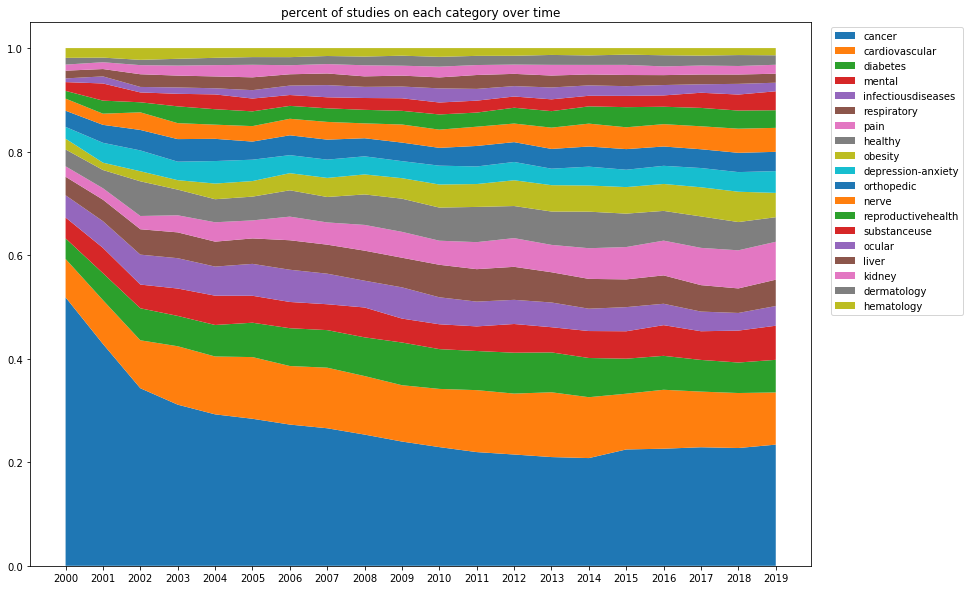

In [135]:
# exludes "other"
plt.figure(figsize=(14,10))
plt.stackplot(df_no_other.columns, 
              [df_no_other.loc[x].values for x in df_no_other.index], 
              labels=df_no_other.index)

plt.legend(bbox_to_anchor=(1.2,1))
plt.title('percent of studies on each category over time')
plt.show()

### let's unstack them to see what is increasing / decreasing over time

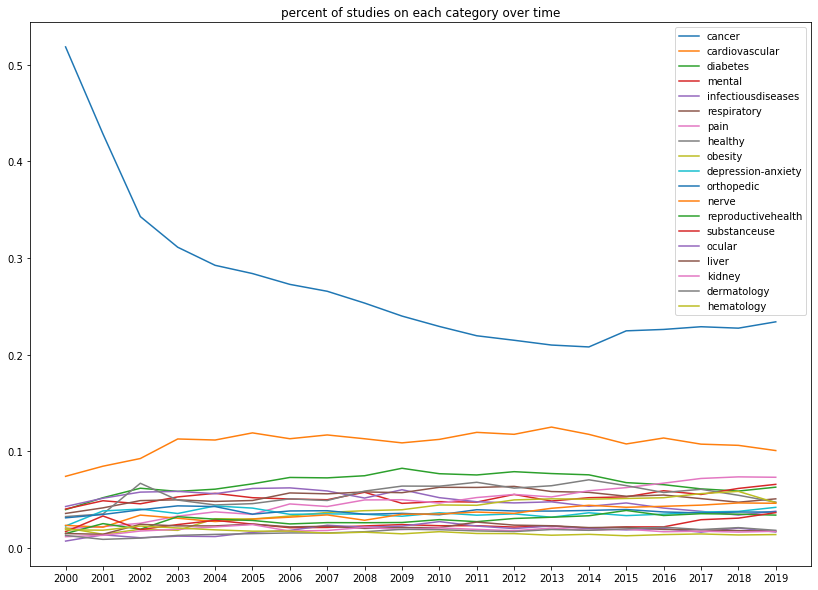

In [136]:
plt.figure(figsize=(14,10))
for idx in df_no_other.index:
    plt.plot(df_no_other.loc[idx].T, label=idx)
    
plt.legend(bbox_to_anchor=(1,1))
plt.title('percent of studies on each category over time')
plt.show()

### we can normalize the data by their 2000 ratios

In [139]:
df_indexed_2000 = df_no_other/ df_no_other['2000'][:, np.newaxis]

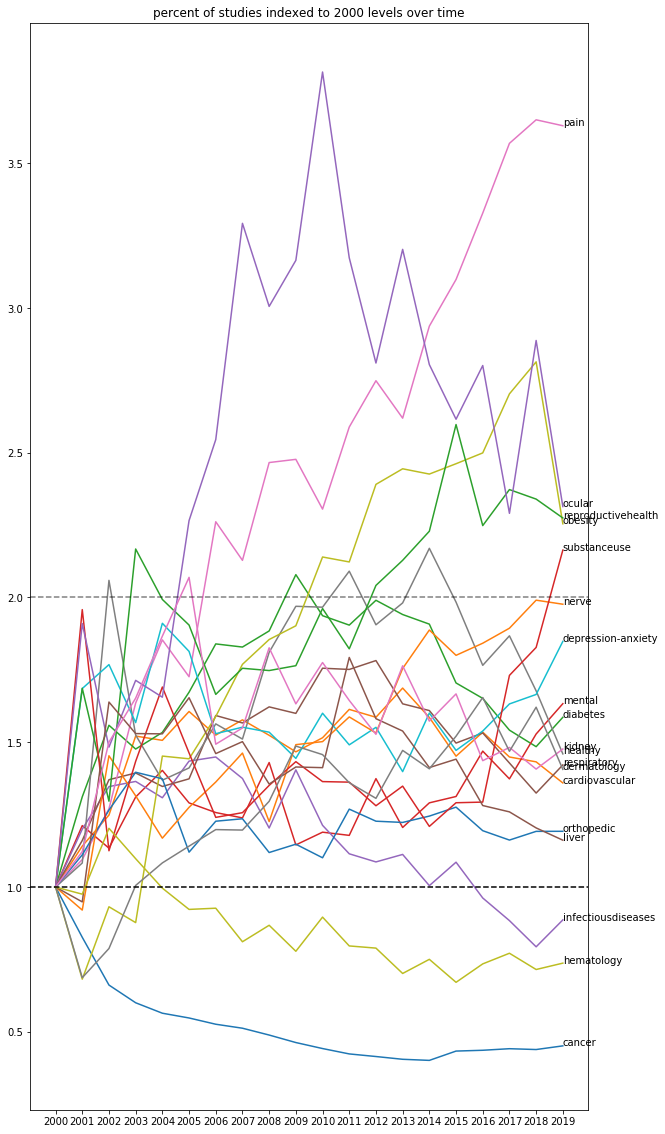

In [153]:
plt.figure(figsize=(10,20))
for idx in df_indexed_2000.index:
    plt.plot(df_indexed_2000.loc[idx].T, label=idx)
    
#plt.legend(bbox_to_anchor=(1,1))
plt.title('percent of studies indexed to 2000 levels over time')

for idx in df_indexed_2000['2019'].index:
    plt.annotate(xy=[19, df_indexed_2000['2019'][idx]], s=idx)
    
plt.axhline(1., linestyle='--', color='k')
plt.axhline(2., linestyle='--', color='k', alpha=0.5)
plt.show()

### This is a bit crowded, so let's plot 6/7 at a time

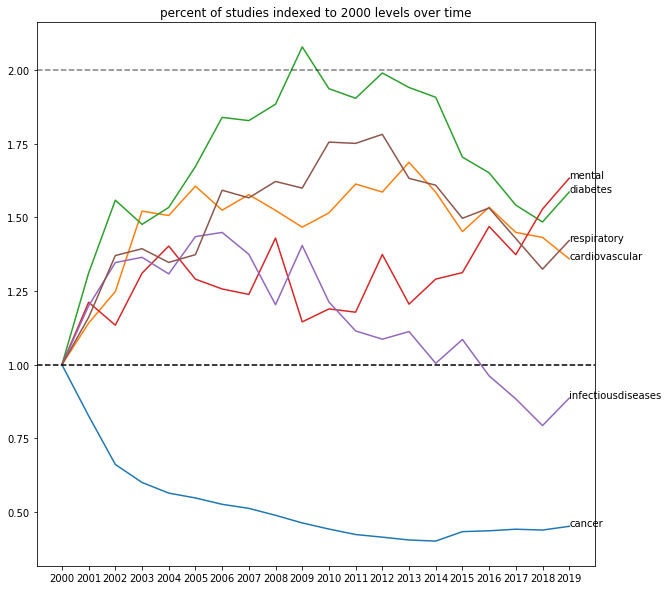

In [157]:
cur_df = df_indexed_2000[0:6]

plt.figure(figsize=(10,10))
for idx in cur_df.index:
    plt.plot(cur_df.loc[idx].T, label=idx)
    
#plt.legend(bbox_to_anchor=(1,1))
plt.title('percent of studies indexed to 2000 levels over time')

for idx in cur_df['2019'].index:
    plt.annotate(xy=[19, cur_df['2019'][idx]], s=idx)
    
plt.axhline(1., linestyle='--', color='k')
plt.axhline(2., linestyle='--', color='k', alpha=0.5)
plt.show()

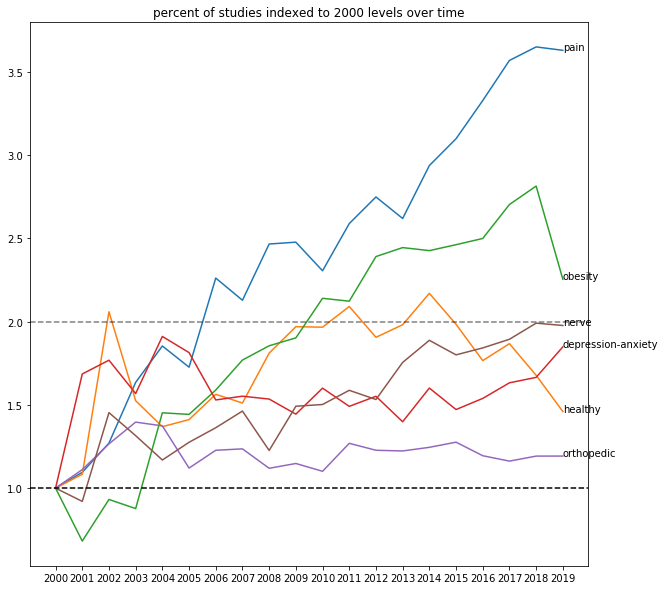

In [158]:
cur_df = df_indexed_2000[6:12]

plt.figure(figsize=(10,10))
for idx in cur_df.index:
    plt.plot(cur_df.loc[idx].T, label=idx)
    
#plt.legend(bbox_to_anchor=(1,1))
plt.title('percent of studies indexed to 2000 levels over time')

for idx in cur_df['2019'].index:
    plt.annotate(xy=[19, cur_df['2019'][idx]], s=idx)
    
plt.axhline(1., linestyle='--', color='k')
plt.axhline(2., linestyle='--', color='k', alpha=0.5)
plt.show()

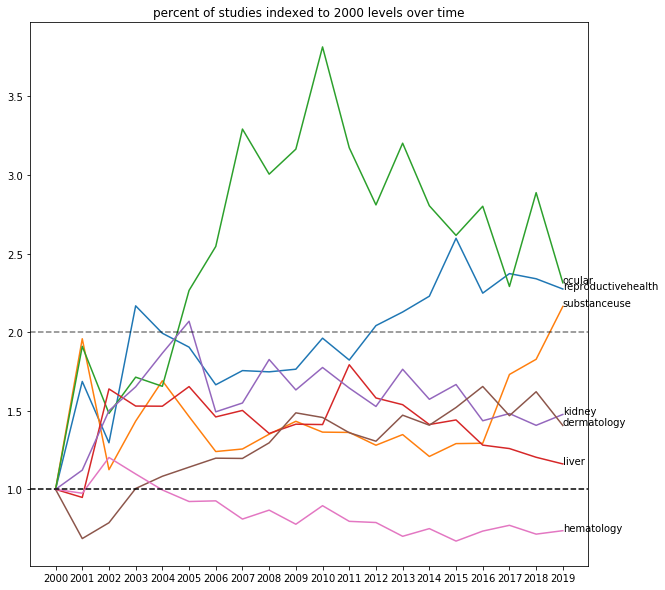

In [159]:
cur_df = df_indexed_2000[12:]

plt.figure(figsize=(10,10))
for idx in cur_df.index:
    plt.plot(cur_df.loc[idx].T, label=idx)
    
#plt.legend(bbox_to_anchor=(1,1))
plt.title('percent of studies indexed to 2000 levels over time')

for idx in cur_df['2019'].index:
    plt.annotate(xy=[19, cur_df['2019'][idx]], s=idx)
    
plt.axhline(1., linestyle='--', color='k')
plt.axhline(2., linestyle='--', color='k', alpha=0.5)
plt.show()